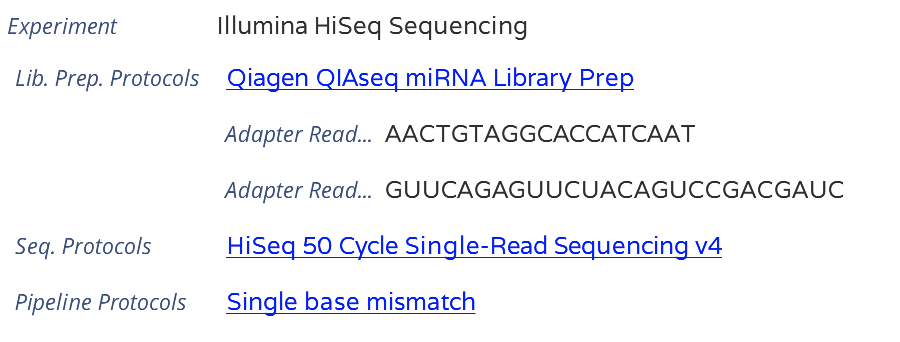

In [1]:
from IPython.display import Image
Image("miRNA-Seq Methods.png", width=500) 

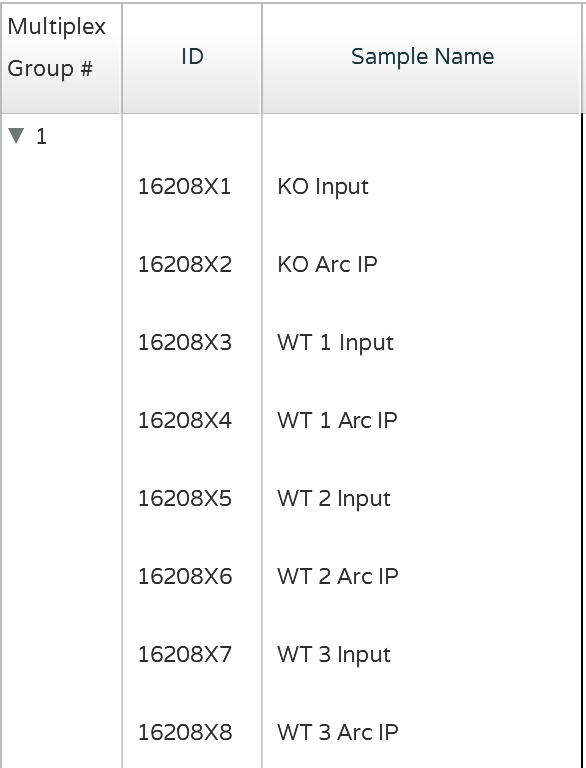

In [2]:
Image("Sample IDs.png", width=300) 

### Trimming task

In [27]:
%%bash
for f in Fastq/*.fastq.gz; do
    out=${f/_R1_001.fastq.gz/.trim.fastq.gz};
    echo cutadapt -j 12 -q 15 -m 15 -a AACTGTAGGCACCATCAAT -o $out $f;
done

cutadapt -j 12 -q 15 -m 15 -a AACTGTAGGCACCATCAAT -o Fastq/16208X3_WT_1_Input.trim.fastq.gz Fastq/16208X3_WT_1_Input_R1_001.fastq.gz
cutadapt -j 12 -q 15 -m 15 -a AACTGTAGGCACCATCAAT -o Fastq/16208X3_WT_1_Input.trim.fastq.gz Fastq/16208X3_WT_1_Input.trim.fastq.gz
cutadapt -j 12 -q 15 -m 15 -a AACTGTAGGCACCATCAAT -o Fastq/16208X4_WT_1_Arc_IP.trim.fastq.gz Fastq/16208X4_WT_1_Arc_IP_R1_001.fastq.gz
cutadapt -j 12 -q 15 -m 15 -a AACTGTAGGCACCATCAAT -o Fastq/16208X4_WT_1_Arc_IP.trim.fastq.gz Fastq/16208X4_WT_1_Arc_IP.trim.fastq.gz


|**Summary** | |
|------|------|
| Total reads processed: | 28,192,485 |
| Reads with adapters: | 22,922,101 (81.3%) |
| Reads that were too short: | 4,348,263 (15.4%) |
| Reads written (passing filters): |  23,844,222 (84.6%) |
| Total basepairs processed: | 1,409,624,250 bp |
| Quality-trimmed: | 707,889 bp (0.1%) |
| Total written (filtered): | 759,775,723 bp (53.9%) |
| **Adapter 1** || 
| Sequence: | AACTGTAGGCACCATCAAT |
| Type: | regular 3'|
| Length: | 19| 
| Trimmed: | 22922101 times. |
|No. of allowed errors: 0-9 bp: 0; 10-19 bp: 1 | |
| **Bases preceding removed adapters:**||
| A: | 16.2% |
| C: | 18.1% |
| G: | 30.5% |
| T: | 35.2% |
| none/other: | 0.0% |


### Alignment task

In [ ]:
%%bash
for f in Fastq/*.trim.fastq.gz; do
    out=${f/.trim.fastq.gz/.bam}   
    bowtie2 --sensitive --end-to-end -N 1 -p 12 -x /rumi/shams/genomes/mm10/mm10 -U $f | samtools view - -Sb  -h -t /rumi/shams/genomes/mm10/mm10.fa.fai -o $out

done&

#### 7971405 reads; of these:
- 7971405 (100.00%) were unpaired; of these:
- 3736669 (46.88%) aligned 0 times
- 1151104 (14.44%) aligned exactly 1 time
- 3083632 (38.68%) aligned >1 times
- 53.12% overall alignment rate

#### 23844222 reads; of these:
- 23844222 (100.00%) were unpaired; of these:
- 10959984 (45.96%) aligned 0 times
- 4318405 (18.11%) aligned exactly 1 time
- 8565833 (35.92%) aligned >1 times
- 54.04% overall alignment rate


#### Sorting _.bam_ files:

In [ ]:
%%bash 
for f in Fastq/*.bam; do
    out=${f/.bam/.srt.bam}
    samtools sort -@12 -o $out $f
done&

### Measure counts

In [ ]:
%%bash
for f in Fastq/*.srt.bam; do
    out=${f/.srt.bam/.gene.fc}
    featureCounts -T 12 -F SAF -P -B -C -O -a /rumi/shams/genomes/mm10/mm10_annotations/mm10_smRNA_miRNA_tRNA.saf -o $out $f;
done&

In [39]:
%%bash
less Fastq/16208X3_WT_1_Input.gene.fc.summary

Status	Fastq/16208X3_WT_1_Input.srt.bam
Assigned	418716
Unassigned_Unmapped	3736669
Unassigned_MappingQuality	0
Unassigned_Chimera	0
Unassigned_FragmentLength	0
Unassigned_Duplicate	0
Unassigned_MultiMapping	0
Unassigned_Secondary	0
Unassigned_Nonjunction	0
Unassigned_NoFeatures	3816020
Unassigned_Overlapping_Length	0
Unassigned_Ambiguity	0


In [40]:
%%bash
less Fastq/16208X4_WT_1_Arc_IP.gene.fc.summary

Status	Fastq/16208X4_WT_1_Arc_IP.srt.bam
Assigned	1169649
Unassigned_Unmapped	10959984
Unassigned_MappingQuality	0
Unassigned_Chimera	0
Unassigned_FragmentLength	0
Unassigned_Duplicate	0
Unassigned_MultiMapping	0
Unassigned_Secondary	0
Unassigned_Nonjunction	0
Unassigned_NoFeatures	11714589
Unassigned_Overlapping_Length	0
Unassigned_Ambiguity	0


### Load R

In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(DESeq2, quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(gridExtra, quietly = TRUE)
library(ggrepel, quietly = TRUE)
library(EnhancedVolcano, quietly = TRUE)
library(ggpubr, quietly = TRUE)

### Read data


In [19]:
%%R
files <- list.files(path = "Fastq", pattern="gene.fc$") 
cond <- c('WT_Input' , 'WT_Arc_IP')
datalist <- lapply(files, function(x){read.table(file=paste('Fastq/', x, sep = "") ,header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
f_name <- unlist(lapply(files, function(i) unlist(strsplit(i, "_"))[1]))
colnames(m) <- f_name
colData <- data.frame(cond, row.names=f_name)

# DE Analysis

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates



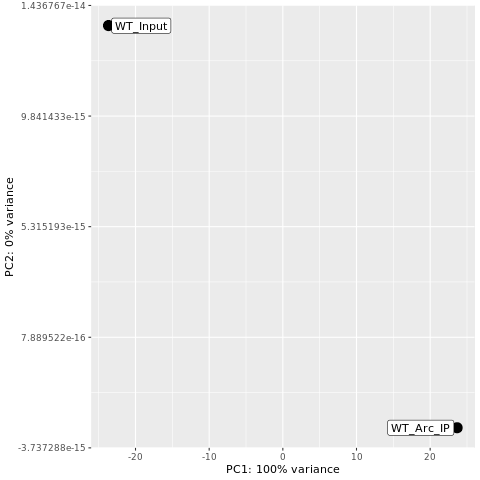

In [20]:
%%R
dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
dds$cond <- relevel(dds$cond, ref="WT_Input")
dds <- DESeq(dds)
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)
# PCA Plot 
z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
percentVar <- round(100 * attr(z, "percentVar"))
p <- ggplot(z, aes(PC1, PC2)) +
  geom_point(aes(size = 4)) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  geom_label_repel(label = cond, force = 10) +
  labs(shape="Cell Lines", colour="Sample Type") +
  guides(size = FALSE)
print (p)

Model
$$WTArcIP - WTInput$$

In [21]:
%%R
# normalized counts 
ncu <- counts(dds, normalized=TRUE)
# Raw tabels 
write.table(ncu, file="Results/miRNA_gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=cond) 
write.table(m, file="Results/miRNA_gene_count_table_raw.txt", sep="\t", quote=FALSE, col.names=cond )
# model:
res <- results(dds) # , contrast=list(c('cond_WT_Arc_IP_vs_WT_Input', 'cond_KO_Input_vs_WT_Input'),
#                                   c('cond_KO_Arc_IP_vs_WT_Input')), listValues=c(1,-1))
write.table(res, "Results/miRNA_WT_Arc_IP_VS_WT_Input.txt", sep="\t", quote=FALSE, col.names=NA)
# # Positive results 
res <- data.frame(res, row.names = rownames(res))
positive_res <- res %>% 
                rownames_to_column('gene') %>%
                filter(log2FoldChange > 0 & pvalue < 1e-1)
positive_ncu <- ncu[positive_res$gene,]
write.table(positive_res, file="Results/miRNA_positive_WT_Arc_IP_VS_WT_Input.txt", sep="\t", quote=FALSE, col.names=NA )
write.table(positive_ncu, file="Results/miRNA_positive_gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=cond) 
resultsNames(dds)

[1] "Intercept"                  "cond_WT_Arc_IP_vs_WT_Input"


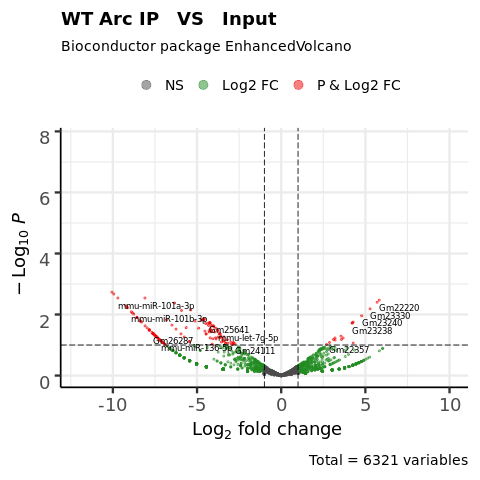

In [22]:
%%R
# Volcano plot 
vol <- EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-12, 10),
    title = 'WT Arc IP   VS   Input',
    pCutoff = 1e-1,
    FCcutoff = 1)
print (vol)

In [23]:
%%R
# check top genes 
top_genes <- rownames (positive_ncu)
myplots <- list() 
check <- data.frame()
for (g in 1:length(top_genes)){
    check <- rbind(check,data.frame(
        'Differential_Expression' = c(
            ncu[top_genes[g],rownames(subset (colData,cond == 'WT_Arc_IP'))],
            ncu[top_genes[g],rownames(subset (colData,cond == 'WT_Input'))]),
        'Conversion' = c('WT_Arc_IP','WT_Input'),
        'Gene' = top_genes[g]))
    rownames(check) <- c()
}

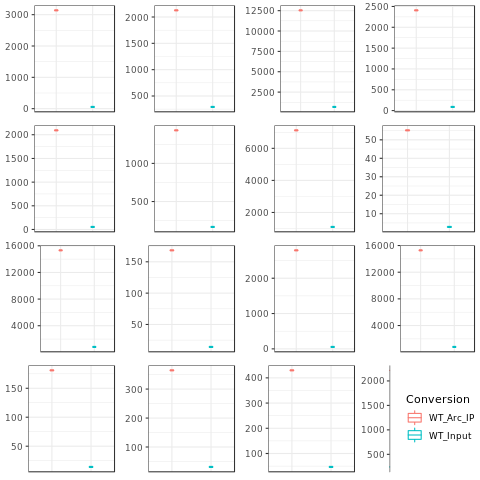

In [24]:
%%R 
# draw plots 
plist <- list()
pcntr <- 1
for (g in unique(check$Gene)){
    p <- ggplot(data = check %>% filter ( Gene == g ), 
                mapping = aes(x = Conversion, y = Differential_Expression, color = Conversion)) +
    geom_boxplot(width=0.1) +
    scale_fill_grey() 
    if (pcntr < length (unique(check$Gene))){
    p <- p +
        theme_bw() + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(),
              axis.ticks.x=element_blank(), axis.title.y=element_blank(), legend.position="none")
    } else {
    p <- p +
        theme_bw() + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(),
              axis.ticks.x=element_blank(), axis.title.y=element_blank(), legend.position = "right")
    }
    plist[[pcntr]] <- p
    pcntr <- pcntr + 1
}
do.call(grid.arrange, c(plist, ncol = 4))

# Systemic analysis 

Merge .bam files:

In [ ]:
%%bash
samtools merge -@ 12 Fastq/all.merged.bam Fastq/*srt.bam
# sort the merged file 
samtools sort -@12 Fastq/all.merged.bam > Fastq/all.merged.srt.bam
# bam to bet
bedtools bamtobed -i Fastq/all.merged.srt.bam > all.merged.srt.bed

In [ ]:
%%bash
###### Systematic ######
Piranha -s -b 500 all.merged.srt.bed -o all.merged.piranha.txt &

In [19]:
ls *piranha.txt

all.merged.piranha.txt


In [ ]:
%%bash
cat *.piranha.txt | sort -k1,1 -k2,2n -k3,3n | mergeBed -s -d 0 -c 6 -o distinct -i stdin | awk '{printf("%s\t%d\t%d\tdsRNA_tag_%d\t1\t%s\n",$1,$2,$3, NR,$4)}' > dsRNA_piranha.bed
awk '{printf("%s\t%s\t%d\t%d\t%s\n",$4,$1,$2+1,$3,$6)}' dsRNA_piranha.bed > dsRNA_piranha.saf

In [21]:
%%bash
featureCounts -T 12 -O -F SAF -a dsRNA_piranha.saf -o 16208X3_WT_1_Input.piranha.fc Fastq/16208X3_WT_1_Input.srt.bam
featureCounts -T 12 -O -F SAF -a dsRNA_piranha.saf -o 16208X4_WT_1_Arc_IP.piranha.fc Fastq/16208X4_WT_1_Arc_IP.srt.bam


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.6.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           S Fastq/16208X3_WT_1_Input.srt.bam               ||
||                                                                            ||
||             Output file : 16208X3_WT_1_Input.piranha.fc                    ||
||                 Summary : 16208X3_WT_1_Input.piranha.fc.summar

In [4]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
%%R
library(DESeq2, quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(gridExtra, quietly = TRUE)
library(ggrepel, quietly = TRUE)
library(EnhancedVolcano, quietly = TRUE)
library(ggpubr, quietly = TRUE)

### Read data


In [16]:
%%R
files <- list.files(path = 'piranha', pattern=".piranha.fc$")

cond <- c('WT_Input' , 'WT_Arc_IP')
datalist <- lapply(files, function(x){read.table(file=paste('piranha/', x, sep = ""),header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
f_name <- unlist(lapply(files, function(i) unlist(strsplit(i, "_"))[1]))
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
f_name <- unlist(lapply(files, function(i) unlist(strsplit(i, "_"))[1]))
colnames(m) <- f_name
colData <- data.frame(cond, row.names=f_name)
head(m)

               16208X3 16208X4
dsRNA_tag_1         53     137
dsRNA_tag_10        38     232
dsRNA_tag_100       49     236
dsRNA_tag_1000      79     136
dsRNA_tag_1001     158     464
dsRNA_tag_1002      90     323


# DE Analysis

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='lo

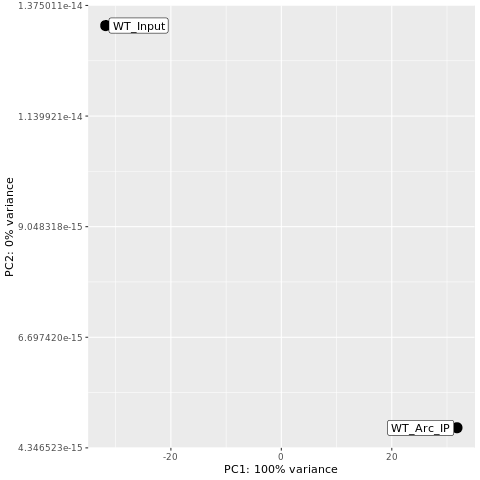

In [17]:
%%R
dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
dds$cond <- relevel(dds$cond, ref="WT_Input")
dds <- DESeq(dds)
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)
# PCA Plot 
z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
percentVar <- round(100 * attr(z, "percentVar"))
p <- ggplot(z, aes(PC1, PC2)) +
  geom_point(aes(size = 4)) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  geom_label_repel(label = cond, force = 10) +
  labs(shape="Cell Lines", colour="Sample Type") +
  guides(size = FALSE)
print (p)

Model
$$WTArcIP - WTInput$$

In [25]:
%%R
# normalized counts 
ncu <- counts(dds, normalized=TRUE)
# Raw tabels 
write.table(ncu, file="Results/piranha_miRNA_gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=cond) 
write.table(m, file="Results/piranha_miRNA_gene_count_table_raw.txt", sep="\t", quote=FALSE, col.names=cond )
# model:
res <- results(dds) # , contrast=list(c('cond_WT_Arc_IP_vs_WT_Input', 'cond_KO_Input_vs_WT_Input'),
#                                   c('cond_KO_Arc_IP_vs_WT_Input')), listValues=c(1,-1))
write.table(res, "Results/piranha_miRNA_WT_Arc_IP_VS_WT_Input.txt", sep="\t", quote=FALSE, col.names=NA)
# # Positive results 
res <- data.frame(res, row.names = rownames(res))
positive_res <- res %>% 
                rownames_to_column('gene') %>%
                filter(log2FoldChange > 0 & pvalue < 1e-1)
positive_ncu <- ncu[positive_res$gene,]
write.table(positive_res, file="Results/piranha_miRNA_positive_WT_Arc_IP_VS_WT_Input.txt", sep="\t", quote=FALSE, col.names=NA )
write.table(positive_ncu, file="Results/piranha_miRNA_positive_gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=cond) 
resultsNames(dds)

[1] "Intercept"                  "cond_WT_Arc_IP_vs_WT_Input"


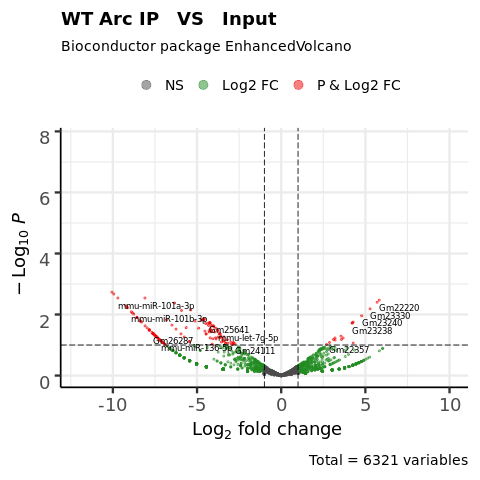

In [26]:
%%R
# Volcano plot 
vol <- EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-12, 10),
    title = 'WT Arc IP   VS   Input',
    pCutoff = 1e-1,
    FCcutoff = 1)
print (vol)

In [27]:
%%R
# check top genes 
top_genes <- rownames (positive_ncu)
myplots <- list() 
check <- data.frame()
for (g in 1:length(top_genes)){
    check <- rbind(check,data.frame(
        'Differential_Expression' = c(
            ncu[top_genes[g],rownames(subset (colData,cond == 'WT_Arc_IP'))],
            ncu[top_genes[g],rownames(subset (colData,cond == 'WT_Input'))]),
        'Conversion' = c('WT_Arc_IP','WT_Input'),
        'Gene' = top_genes[g]))
    rownames(check) <- c()
}

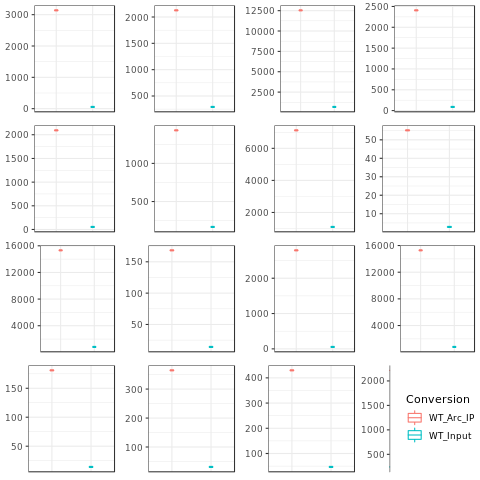

In [28]:
%%R 
# draw plots 
plist <- list()
pcntr <- 1
for (g in unique(check$Gene)){
    p <- ggplot(data = check %>% filter ( Gene == g ), 
                mapping = aes(x = Conversion, y = Differential_Expression, color = Conversion)) +
    geom_boxplot(width=0.1) +
    scale_fill_grey() 
    if (pcntr < length (unique(check$Gene))){
    p <- p +
        theme_bw() + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(),
              axis.ticks.x=element_blank(), axis.title.y=element_blank(), legend.position="none")
    } else {
    p <- p +
        theme_bw() + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(),
              axis.ticks.x=element_blank(), axis.title.y=element_blank(), legend.position = "right")
    }
    plist[[pcntr]] <- p
    pcntr <- pcntr + 1
}
do.call(grid.arrange, c(plist, ncol = 4))